In [ ]:

import pandas as pd 
import numpy as np 
from utils import * 
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from src.files import InterProScanFile
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.gridspec import GridSpec
import glob
from src import get_genome_id
import os
from scipy.stats import pearsonr
from src.tools import MMSeqs
import dataframe_image as dfi
import warnings
import re
warnings.simplefilter('ignore')

%load_ext autoreload
%autoreload 2

confusion_matrix_map = {'tp':'true positive', 'fp':'false positive', 'tn':'true negative', 'fn':'false negative'}


# TODO: How does the model behave on short sequences versus long sequences? Is it picking up the spurious short ORFs?
# TODO: Find the pairwise distances between AntiFam sequences and model-predicted spurious sequences. 
# TODO: What fraction of each category are predicted spurious?
# TODO: I wonder if I could re-try fine-tuning by selecting sequences which are real and spurious with high probability (maybe 0.95 cutoff).
# TODO: Find a way to see if the model is robust to truncation and/or extension.
# TODO: Take a close look at the things which seem to be false positives or false negatives, like matches with high likelihood for being spurious, and 
#   conflicts with a high likelihood for being real. 


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [145]:
def apply_threshold(results_df:pd.DataFrame, threshold:float=0.5):
    results_df = results_df[(results_df['model_output_0'] > threshold) & (results_df.model_output_1 > threshold)].copy()
    return results_df

def load_interpro(genome_ids, dir_:str='../data/interpro/'):
    df = [InterProScanFile(os.path.join(dir_, f'{genome_id}_annotation.tsv')).to_df() for genome_id in tqdm(genome_ids, desc='load_interpro')]
    return pd.concat(df) 

def has_interpro_hit(df:pd.DataFrame, max_e_value:float=2000, include_mdb:bool=True):
    has_hit = ~df.interpro_analysis.isin(['AntiFam', 'none']) # Don't include the AntiFam hits as "hits."
    e_values = df.interpro_e_value
    if include_mdb: # Because the MobiDBLite hits don't have an associated E-value.
        e_values = e_values.fillna(max_e_value) 
    return has_hit & (e_values <= max_e_value)

has_antifam_hit = lambda df : df.interpro_analysis == 'AntiFam'

is_suspect = lambda df : (df.top_hit_product == 'hypothetical protein') & (df.top_hit_evidence_type == 'ab initio prediction')
is_suspect_match = lambda df : is_suspect(df) & (df.category == 'match')
is_intergenic = lambda df : (df.category == 'intergenic')

# Compute the traditional sequence identity (with match score 1, gap score 0, and mismatch score 0).
get_sequence_identity_ = lambda df : (df.alignment_length - (df.n_gaps + df.n_mismatches)) / df.alignment_length 


In [107]:
model_name = 'campylobacterota_v3'

results_df = pd.read_csv('../data/results/prodigal_predict.csv', index_col=0)
results_df = results_df.rename(columns={col:col.replace(model_name, 'model') for col in results_df.columns})
results_df = results_df.merge(pd.read_csv('../data/prodigal.csv', index_col=0), left_index=True, right_index=True)

genome_metadata_df = pd.read_csv('../data/genome_metadata.csv', index_col=0)
results_df['gc_percent'] = results_df.genome_id.map(genome_metadata_df['gc_percent'])

interpro_df = load_interpro(results_df.genome_id.unique())
interpro_df = interpro_df.sort_values('interpro_e_value')
interpro_df = interpro_df[~interpro_df.index.duplicated(keep='first')]

results_df = results_df.drop(columns=interpro_df.columns, errors='ignore').merge(interpro_df, left_index=True, right_index=True, how='left')
results_df['interpro_analysis'] = np.where(results_df.interpro_analysis.isnull(), 'none', results_df.interpro_analysis)
results_df['interpro_hit'] = ~results_df.interpro_analysis.isin(['AntiFam', 'none'])

load_interpro: 100%|██████████| 197/197 [00:17<00:00, 11.44it/s]


In [ ]:
def table_1(results_df:pd.DataFrame):

    threshold = 0.99
    df = pd.DataFrame(index=results_df.category.unique())
    df['total'] = results_df.groupby('category').apply(len, include_groups=False)
    df['num_predicted_spurious'] = apply_threshold(results_df, threshold=threshold).groupby('category').apply(lambda df : (df.model_label == 0).sum(), include_groups=False)
    df['frac_predicted_spurious'] = df.num_predicted_spurious / df.total


,total,num_predicted_spurious,frac_predicted_spurious
match,400331,1006,0.002513
intergenic,4372,784,0.179323
pseudogene,5347,131,0.024500
conflict,877,568,0.647662


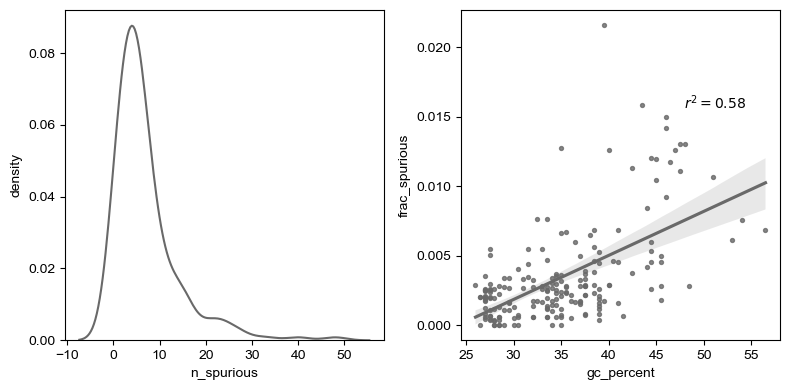

In [142]:
def figure_1(results_df, threshold:float=0.5):

    # fig = plt.figure(layout='tight')
    # grid = GridSpec(nrows=3, ncols=2, figure=fig) # , width_ratios=[0.6, 0.4])
    # ax_a = fig.add_subplot(grid[:, 0])
    # ax_b = [fig.add_subplot(grid[i, 1]) for i in range(3)]

    fig, (ax_a, ax_b) = plt.subplots(ncols=2, figsize=(8, 4))

    results_df = apply_threshold(results_df, threshold=threshold)
    genomes = results_df.groupby('genome_id')

    ax_df = pd.DataFrame(index=results_df['genome_id'].unique())
    ax_df['gc_percent'] = genomes.gc_percent.first()
    ax_df['genome_size'] = genomes.apply(len, include_groups=False)
    ax_df['n_spurious'] = genomes.apply(lambda df : (df.model_label == 0).sum(), include_groups=False)
    ax_df['n_spurious_match'] = genomes.apply(lambda df : ((df.model_label == 0) & (df.category == 'match')).sum(), include_groups=False)
    ax_df['n_spurious_intergenic'] = genomes.apply(lambda df : ((df.model_label == 0) & (df.category == 'intergenic')).sum(), include_groups=False)
    ax_df['n_spurious_conflict'] = genomes.apply(lambda df : ((df.model_label == 0) & (df.category == 'conflict')).sum(), include_groups=False)
    
    ax_df['n_intergenic'] = genomes.apply(lambda df : (df.category == 'intergenic').sum(), include_groups=False)
    ax_df['n_conflict'] = genomes.apply(lambda df : (df.category == 'conflict').sum(), include_groups=False)
    
    ax_df['frac_spurious'] = ax_df.n_spurious / ax_df.genome_size
    ax_df['frac_intergenic'] = ax_df.n_intergenic / ax_df.genome_size
    ax_df['frac_conflict'] = ax_df.n_conflict / ax_df.genome_size

    sns.kdeplot(data=ax_df, x='n_spurious', ax=ax_a, label='spurious', color='dimgray', linestyle='-')
    ax_a.set_ylabel('density')

    palette = {'frac_spurious':'dimgray', 'frac_conflict':'indianred', 'frac_intergenic':'steelblue'}

    sns.regplot(data=ax_df, x='gc_percent', y='frac_spurious', ax=ax_b, color=palette.get('frac_spurious'), scatter_kws={'s':8})
    r = pearsonr(ax_df['gc_percent'].values, ax_df['frac_spurious'].values)
    ax_b.text(0.7, 0.7, f'$r^2={r.statistic:.2f}$', transform=ax_b.transAxes)

    fig.tight_layout()
    plt.show()

figure_1(results_df, threshold=0.99)

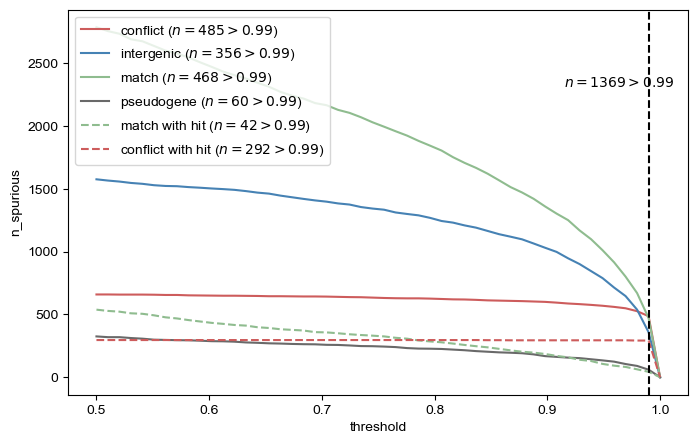

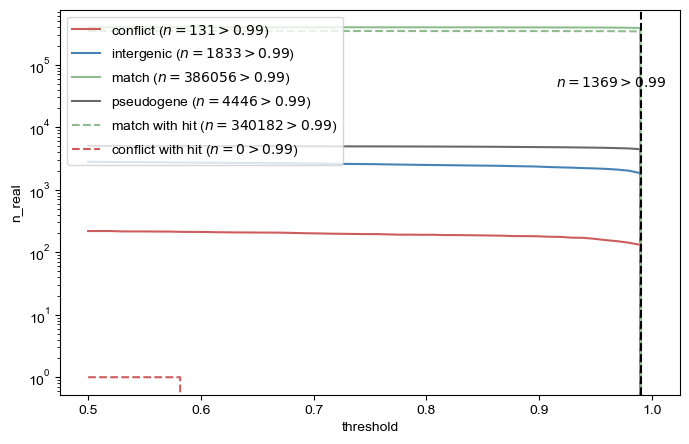

In [136]:
def figure(results_df:pd.DataFrame, path:str=None, threshold:float=0.99, label:int=0, log_scale:bool=False):

    results_df = results_df.copy()
    results_df['interpro_hit'] = has_interpro_hit(results_df, include_mdb=False)
    results_df['antifam_hit'] = has_antifam_hit(results_df)

    thresholds = np.linspace(0.5, 1, 50)
    y_label = 'n_spurious' if (label == 0) else 'n_real'

    fig, ax = plt.subplots(figsize=(8, 5))

    def get_ax_df(df:pd.DataFrame):
        ax_df = pd.DataFrame(index=np.arange(len(thresholds)))
        ax_df['threshold'] = thresholds
        ax_df[y_label] = [(df[f'model_output_{label}'] > threshold_).sum() for threshold_ in thresholds]
        return ax_df

    palette = {'intergenic':'steelblue', 'conflict':'indianred', 'match':'darkseagreen', 'pseudogene':'dimgray'}
    for category, df in results_df.groupby('category'):
        n = (df[f'model_output_{label}'] > threshold).sum()
        sns.lineplot(ax=ax, data=get_ax_df(df), x='threshold', y=y_label, color=palette.get(category), label=f'{category} ($n={n} > {threshold}$)')
    
    df = results_df[(results_df.category == 'match') & results_df.interpro_hit]
    n = (df[f'model_output_{label}'] > threshold).sum()
    sns.lineplot(ax=ax, data=get_ax_df(df), x='threshold', y=y_label, color=palette.get('match'), linestyle='--', label=f'match with hit ($n={n} > {threshold}$)')

    df = results_df[(results_df.category == 'conflict') & results_df.antifam_hit]
    n = (df[f'model_output_{label}'] > threshold).sum()
    sns.lineplot(ax=ax, data=get_ax_df(df), x='threshold', y=y_label, color=palette.get('conflict'), linestyle='--', label=f'conflict with hit ($n={n} > {threshold}$)')
    
    sns.move_legend(ax, 'lower left')
    ax.legend(loc='upper left')

    ax.axvline(x=threshold, linestyle='--', color='black')
    n = (results_df.model_output_0 > threshold).sum()
    ax.text(0.8, 0.8, f'$n={n} > {threshold}$', transform=ax.transAxes)

    if log_scale:
        ax.set_yscale('log')

    plt.show()

figure(results_df, label=0)
figure(results_df, label=1, log_scale=True)


In [137]:
dataset_df = pd.read_csv('../data/dataset_dereplicated.csv', index_col=0)

# Going to try fine-tuning the model using the Prodigal data, though I don't want to train it on a bunch of sequences which 
# are basically already in the training dataset (i.e. all of the high-confidence match sequences). 

threshold = 0.99
label_1_mask = (results_df.model_output_1 > threshold) & ~((results_df.category == 'match') & (results_df.top_hit_protein_id.isin(dataset_df.index)))
label_0_mask = (results_df.model_output_0 > threshold)

print('Adding', label_1_mask.sum(), 'likely "real" sequences to the tuning dataset.')
print('Adding', label_0_mask.sum(), 'likely "spurious" sequences to the tuning dataset.')

tune_dataset_df = list()
tune_dataset_df += [results_df[label_1_mask].assign(label=1)]
tune_dataset_df += [results_df[label_0_mask].assign(label=0)]
tune_dataset_df = pd.concat(tune_dataset_df)

tune_dataset_df.to_csv('../data/dataset_tune.csv')


Adding 46979 likely "real" sequences to the tuning dataset.
Adding 1369 likely "spurious" sequences to the tuning dataset.


In [146]:
df = apply_threshold(results_df, threshold=0.99)

print(df[df.category == 'intergenic'].seq.apply(len).mean())
print(df[(df.category == 'intergenic') & (df.model_label == 0)].seq.apply(len).mean())

AttributeError: 'DataFrame' object has no attribute 'seq'

In [143]:
# Something weird seems to be happening where a lot of the "suspect" sequences have similar sequences in other genomes, 
# and sometimes in the same genome. Sometimes the sequences they aligned to are annotated, though most are hypothetical. 
# It is not clear to me why these sequences were not recognized by PGAP. I did check to make sure there were no bugs in my code,
# and the sequences I have as "suspect matches" are indeed aligned to suspect sequences in the reference genome.

In [144]:
# First curious about the intergenic sequences, many of which I suspect are actually spurious. 
# Some are probaly actually conflicts, because of how lenient I was about the overlap length. 

# There seems to be no real correlation between overlap length and model output. 

# I was worried that the model would fail to catch some of the short, spurious ORFs that might
# not have any homology to known spurious translations. However, this does not seem to be the case. 

# What is making the model decide that some intergenic sequences are real and some are spurious?
# Do any of them bear any homology to known sequences? Could do an MMSeqs alignment against all the
# Campylobacterota sequences. 

    